In [71]:
#Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

#Import required packages
import sys,os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import kagglehub

#Add the repo root (one level up from this notebook) to sys.path
sys.path.insert(0, os.path.abspath("../"))

from extensions.vectorization_and_tokenization import multi_column_vectorizer, basic_word_tokenizer, lemmatization_tokenizer, stemming_tokenizer
from courselib.utils.metrics import binary_accuracy, accuracy
from extensions.sparse_array_compatible_models import LogisticRegression_S, LinearSVM_S
from courselib.models.nn import MLP
from courselib.optimizers import GDOptimizer
import time
from IPython.display import clear_output, display
import scipy.sparse as sp
from courselib.utils.normalization import standardize
from extensions.normalization_ext import standardize_sparse_matrix

#Install necessary resources from nltk
import nltk

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [72]:
#Download latest version of dataset
print("Load or download dataset...")
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset") #path to downloaded dataset
#   (if already downloaded, will not download again)

fake_path=os.path.join(path, "Fake.csv")    #path to dataset with true news
true_path=os.path.join(path, "True.csv")    #path to dataset with fake news

#Read into dataframes
print("Loading fake.csv ...")
fake_df=pd.read_csv(fake_path)
print("Loading true.csv ...")
true_df=pd.read_csv(true_path)

#Label data (1=true, 0=fakenews)
true_df['label']=1
fake_df['label']=0

#Join dataframes
df=pd.concat([true_df, fake_df])
print("Done")


Load or download dataset...
Loading fake.csv ...
Loading true.csv ...
Done


In [73]:
from courselib.utils.splits import train_test_split

training_data_fraction=.8

#Split
df_, train_df, test_df=train_test_split(df, training_data_fraction=training_data_fraction, class_column_name='label', return_numpy=False)

In [74]:
from courselib.utils.preprocessing import labels_encoding

Y_train=train_df['label'].to_numpy()
Y_test=test_df['label'].to_numpy()

Y_train_neg=Y_train.copy()
Y_train_neg[Y_train_neg==0]=-1
Y_test_neg=Y_test.copy()
Y_test_neg[Y_test_neg==0]=-1

Y_train_enc=labels_encoding(Y_train, labels=[0,1])
Y_test_enc=labels_encoding(Y_test, labels=[0,1])

Y_TRAIN={'LogisticRegression': Y_train, 'LinearSVM': Y_train_neg, 'MLP': Y_train_enc}
Y_TEST={'LogisticRegression': Y_test, 'LinearSVM': Y_test_neg, 'MLP': Y_test_enc}

In [75]:
from extensions.sparse_array_compatible_models import LogisticRegression_S, LinearSVM_S
from courselib.models.nn import MLP
from courselib.utils.metrics import binary_accuracy, accuracy

ACCURACIES={'LogisticRegression': lambda y_pred, y_true: binary_accuracy(y_pred=y_pred, y_true=y_true, class_labels=[0,1]),
             'LinearSVM': lambda y_pred, y_true: binary_accuracy(y_pred=y_pred, y_true=y_true, class_labels=[-1,1]),
               'MLP': accuracy}

In [76]:
from courselib.models.svm import BinaryKernelSVM

In [ ]:

column_order=['sparse','z-score','columns','model', '# epochs','learning rate','batch size','C','widths','activation','vectorization','tokenizer','stop_words',
    'ngram range','# features','train accuracy [%]','test accuracy [%]','vectorization time [s]','training time [s]'
    ]



def run_experiments(z_score_options,sparse_options, columns_list, models, C_list, hidden_layer_widths_list, vectorizations, tokenizers, stop_words_options, ngram_ranges,
                     max_features_list, activations, lrs, bss, epochs_list, compute_metrics=False, metrics_dict=None,filename=None):
    try:
        results=[]
        result_df=pd.DataFrame({})
        METRICS_HISTORIES=[]
        
        def display_results():
            df_result=pd.DataFrame(results, columns=column_order)
            clear_output(wait=True)
            display(df_result.style.hide(axis="index"))

        vect_configs=[{'vectorization': vectorization,
                        'tokenizer': tok_name,
                        'stop_words': stop_words,
                        'ngram range': ngrams,
                        'max features': max_features,
                        'z-score': z_score, 
                        'columns': columns, 
                        'sparse': sparse}
                    for sparse in sparse_options for z_score in z_score_options for columns in columns_list for max_features in max_features_list
                    for ngrams in ngram_ranges for vectorization in vectorizations for stop_words in stop_words_options
                    for tok_name in tokenizers.keys() if not (max_features is None and not sparse)] 
                    #non sparse computation takes to much storage if max_features None (i.e. unbounded)
        

        for vcf in vect_configs:
            #Vectorize:
            vect_start=time.time()
            vectorizer=multi_column_vectorizer(col_names=vcf['columns'], vectorization=vcf['vectorization'], max_features_per_column=vcf['max features'],
                                            ngram_range=vcf['ngram range'], stop_words=vcf['stop_words'], tokenizer=tokenizers[vcf['tokenizer']])
            X_train=vectorizer.fit_transform(train_df, sparse=vcf['sparse'])
            X_test=vectorizer.transform(test_df, sparse=vcf['sparse'])
            
            length=X_train.shape[0] #length of X_train
            
            if vcf['z-score']:
                #Apply z-score normalization
                if vcf['sparse']:
                    X=sp.vstack([X_train, X_test])
                    X, offset=standardize_sparse_matrix(X)
                    X_train, X_test=X[:length], X[length:]
                else:
                    X=np.vstack([X_train, X_test])
                    X=standardize(X)
                    X_train, X_test=X[:length], X[length:]
                    offset=None
            else:
                offset=None
                    
            vect_end=time.time()
            
            num_features=X_train.shape[1]
            
            models_configs=[]
            models_configs+=[{'model':'LogisticRegression',
                            'activation': None,
                            'C': None,
                            'widths':None, 
                            '# epochs': epochs,
                            'learning rate': lr,
                            'batch size':bs}
                            for m in models for epochs in epochs_list for bs in bss
                            for lr in lrs if m=='LogisticRegression'] #Add LinearRegression models
            
            models_configs+=[{'model':'LinearSVM',
                            'activation': None,
                            'C': C,
                            'widths':None, 
                            '# epochs': epochs,
                            'learning rate': lr,
                            'batch size':bs}
                            for m in models for epochs in epochs_list 
                            for bs in bss for lr in lrs for C in C_list if m=='LinearSVM'] #Add LinearSVM models
            
            models_configs+=[{'model':'MLP',
                            'activation': activation,
                            'C': None,
                            'widths':[num_features]+hidden_layer_widths+[2], 
                            '# epochs': epochs,
                            'learning rate': lr,
                            'batch size':bs}
                            for m in models for epochs in epochs_list for lr in lrs for hidden_layer_widths in hidden_layer_widths_list
                            for bs in bss for activation in activations   #Add MLP models
                            if m=='MLP'if not vcf['sparse']]  # our MLP models don't support sparse matrix computations)

            #Initialize optimizers
            optimizers={lr: GDOptimizer(lr) for lr in lrs}

            for mcf in models_configs:
                modelname=mcf['model']
                y_train=Y_TRAIN[modelname]
                y_test=Y_TEST[modelname]
                #Initialize model
                if modelname=='LogisticRegression':
                    model=LogisticRegression_S(w=np.zeros(num_features), b=0, optimizer=optimizers[mcf['learning rate']], offset=offset)
                elif modelname=='LinearSVM':
                    model=LinearSVM_S(w=np.zeros(num_features), b=0, optimizer=optimizers[mcf['learning rate']], C=mcf['C'], offset=offset)
                elif modelname=='MLP':
                    model=MLP(widths=mcf['widths'], optimizer=optimizers[mcf['learning rate']], activation=mcf['activation'])
                else:
                    raise Exception(f'Unsupported model: {modelname}')

                #Train model
                train_start=time.time()
                metrics_dict_=metrics_dict
                if not metrics_dict is None and'accuracy' in metrics_dict:
                    metrics_dict_['accuracy']=ACCURACIES[modelname]
                metrics_history=model.fit(X_train, y=y_train, num_epochs=mcf['# epochs'], batch_size=mcf['batch size'],
                                           compute_metrics=compute_metrics, metrics_dict=metrics_dict_)
                train_end=time.time()
                #Evaluate
                train_accuracy=np.round(ACCURACIES[modelname](y_pred=model.decision_function(X_train), y_true=y_train),4)
                test_accuracy=np.round(ACCURACIES[modelname](y_pred=model.decision_function(X_test), y_true=y_test),4)

                #Save and display results

                result={'# features': num_features,
                        'vectorization time [s]': np.round(vect_end-vect_start,2),
                        'train accuracy [%]': train_accuracy,
                        'test accuracy [%]': test_accuracy,
                        'training time [s]': np.round(train_end-train_start,2)
                        }
                result.update(vcf) #Save vectorization configs
                result.update(mcf) #Save model configs
                results.append(result)
                METRICS_HISTORIES.append((result, metrics_history))
                display_results()

        result_df=pd.DataFrame(results)
        return result_df, METRICS_HISTORIES
    except KeyboardInterrupt:
        print('interrupted')
    finally:
        if filename is not  None:
            result_df.to_csv(filename)
        
    

             

    
    
        
    

    
                                                    
                                            

                                            
                        
                        
                        
                
        
        
        

In [82]:
columns=['sparse','z-score','model', '# epochs','batch size','C','widths','activation','# features','train accuracy [%]','test accuracy [%]','vectorization time [s]','training time [s]'
    ]

In [83]:
result_dff=result_df[columns]

In [85]:
result_dff.describe()

,# epochs,batch size,C,# features,train accuracy [%],test accuracy [%],vectorization time [s],training time [s]
count,240.000000,240.000000,180.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,37.000000,18009.000000,20.333333,4363.200000,72.934336,72.643997,1.055000,13.091042
std,44.792408,17946.427418,21.356249,7652.973954,18.713156,18.489563,0.322332,28.058325
min,1.000000,100.000000,1.000000,100.000000,52.333100,52.160400,0.800000,0.000000
25%,1.000000,100.000000,1.000000,100.000000,52.333100,52.160400,0.880000,0.247500
50%,10.000000,18009.000000,10.000000,1000.000000,84.535600,84.682650,0.935000,1.085000
75%,100.000000,35918.000000,50.000000,1000.000000,88.513400,88.830700,1.200000,8.980000
max,100.000000,35918.000000,50.000000,19616.000000,100.000000,96.180400,1.930000,121.320000


In [86]:
result_dff[(result_dff['test accuracy [%]']>96)| (result_dff['train accuracy [%]']>99)]

,sparse,z-score,model,# epochs,batch size,C,widths,activation,# features,train accuracy [%],test accuracy [%],vectorization time [s],training time [s]
218,True,True,LogisticRegression,10,100,NaN,None,None,19616,99.7132,96.1804,0.89,2.36
220,True,True,LogisticRegression,100,100,NaN,None,None,19616,100.0000,95.5457,0.89,21.83
232,True,True,LinearSVM,10,35918,10.0,None,None,19616,99.2733,95.8686,0.89,0.17
238,True,True,LinearSVM,100,35918,10.0,None,None,19616,99.9248,94.2984,0.89,1.07
239,True,True,LinearSVM,100,35918,50.0,None,None,19616,99.4543,93.2739,0.89,0.92


In [236]:
len([1,2,3])

TypeError: 'int' object is not callable

In [232]:
tokenizers={'None': None}
columns_list=[['title']]
models=['LogisticRegression','LinearSVM']

lrs=[0.01] # learining rates
max_features_list=[None] # list maximal features to consider
C_list=[10] #C values for SVM
hidden_layer_widths_list=[[10], [100]]  # list widths of hidden layers (everything except input and output layer)
vectorizations=['tf-idf']
stop_words_options=[None]
ngram_ranges=[(1,1)]
epochs_list=[10,100] #  number of epochs
bss=[100,len(train_df)]# full batch
z_score_options=[True] #whether to apply z-score normalization after vectorization
sparse_options=[True]
activations=['ReLU']

TypeError: 'int' object is not callable

In [231]:
result_df, histories=run_experiments(z_score_options,sparse_options, columns_list, models, C_list, hidden_layer_widths_list, vectorizations, tokenizers, stop_words_options, ngram_ranges,
                     max_features_list, activations, lrs, bss, epochs_list, filename=None)

sparse,z-score,columns,model,# epochs,learning rate,batch size,C,widths,activation,vectorization,tokenizer,stop_words,ngram range,# features,train accuracy [%],test accuracy [%],vectorization time [s],training time [s]
True,True,['title'],LogisticRegression,10,0.010000,35918,nan,None,None,tf-idf,None,None,"(1, 1)",19616,96.358400,94.532300,0.980000,0.230000
True,True,['title'],LogisticRegression,100,0.010000,35918,nan,None,None,tf-idf,None,None,"(1, 1)",19616,97.263200,95.111400,0.980000,0.990000
True,True,['title'],LinearSVM,10,0.010000,35918,10.000000,None,None,tf-idf,None,None,"(1, 1)",19616,99.273300,95.868600,0.980000,0.190000
True,True,['title'],LinearSVM,100,0.010000,35918,10.000000,None,None,tf-idf,None,None,"(1, 1)",19616,99.924800,94.298400,0.980000,0.940000


In [183]:
tokenizers={'None': None}
columns_list=[['title']]
models=['LogisticRegression','LinearSVM']

lrs=[0.0001, 0.001, 0.01] # learining rates
max_features_list=[None] # list maximal features to consider
C_list=[10] #C values for SVM
hidden_layer_widths_list=[[10], [100]]  # list widths of hidden layers (everything except input and output layer)
vectorizations=['tf-idf']
stop_words_options=[None]
ngram_ranges=[(1,1)]
epochs_list=[10] #  number of epochs
bss=[100,len(train_df)]# full batch
z_score_options=[True] #whether to apply z-score normalization after vectorization
sparse_options=[True]
activations=['ReLU']

In [ ]:
result_df, histories=run_experiments(z_score_options,sparse_options, columns_list, models, C_list, hidden_layer_widths_list, vectorizations, tokenizers, stop_words_options, ngram_ranges,
                     max_features_list, activations, lrs, bss, epochs_list, compute_metrics=True, metrics_dict={'accuracy':None}, filename='Comparison_models.csv')

sparse,z-score,columns,model,# epochs,learning rate,batch size,C,widths,activation,vectorization,tokenizer,stop_words,ngram range,# features,train accuracy [%],test accuracy [%],vectorization time [s],training time [s]
True,True,['title'],LogisticRegression,10,0.000100,100,nan,None,None,tf-idf,None,None,"(1, 1)",19616,96.698000,94.721600,0.600000,7.510000
True,True,['title'],LogisticRegression,10,0.001000,100,nan,None,None,tf-idf,None,None,"(1, 1)",19616,98.362900,95.935400,0.600000,8.450000
True,True,['title'],LogisticRegression,10,0.010000,100,nan,None,None,tf-idf,None,None,"(1, 1)",19616,99.707700,96.180400,0.600000,7.090000
True,True,['title'],LogisticRegression,10,0.000100,35918,nan,None,None,tf-idf,None,None,"(1, 1)",19616,96.233100,94.443200,0.600000,0.080000
True,True,['title'],LogisticRegression,10,0.001000,35918,nan,None,None,tf-idf,None,None,"(1, 1)",19616,96.249800,94.487800,0.600000,0.080000
True,True,['title'],LogisticRegression,10,0.010000,35918,nan,None,None,tf-idf,None,None,"(1, 1)",19616,96.358400,94.532300,0.600000,0.080000
True,True,['title'],LinearSVM,10,0.000100,100,10.000000,None,None,tf-idf,None,None,"(1, 1)",19616,99.384700,94.465500,0.600000,9.060000
True,True,['title'],LinearSVM,10,0.001000,100,10.000000,None,None,tf-idf,None,None,"(1, 1)",19616,96.394600,91.837400,0.600000,8.090000
True,True,['title'],LinearSVM,10,0.010000,100,10.000000,None,None,tf-idf,None,None,"(1, 1)",19616,87.421300,85.066800,0.600000,8.530000
True,True,['title'],LinearSVM,10,0.000100,35918,10.000000,None,None,tf-idf,None,None,"(1, 1)",19616,96.233100,94.443200,0.600000,0.380000


In [205]:
result_df, histories=run_experiments(z_score_options,sparse_options, columns_list, models, C_list, hidden_layer_widths_list, vectorizations, tokenizers, stop_words_options, ngram_ranges,
                     max_features_list, activations, lrs, bss, epochs_list, compute_metrics=False, metrics_dict={'accuracy':None}, filename='Comparison_models.csv')

sparse,z-score,columns,model,# epochs,learning rate,batch size,C,widths,activation,vectorization,tokenizer,stop_words,ngram range,# features,train accuracy [%],test accuracy [%],vectorization time [s],training time [s]
True,True,['title'],LogisticRegression,10,0.000100,100,nan,None,None,tf-idf,None,None,"(1, 1)",19616,96.695300,94.721600,0.810000,2.400000
True,True,['title'],LogisticRegression,10,0.001000,100,nan,None,None,tf-idf,None,None,"(1, 1)",19616,98.365700,95.946500,0.810000,2.290000
True,True,['title'],LogisticRegression,10,0.010000,100,nan,None,None,tf-idf,None,None,"(1, 1)",19616,99.710500,96.180400,0.810000,2.270000
True,True,['title'],LogisticRegression,10,0.000100,35918,nan,None,None,tf-idf,None,None,"(1, 1)",19616,96.233100,94.443200,0.810000,0.100000
True,True,['title'],LogisticRegression,10,0.001000,35918,nan,None,None,tf-idf,None,None,"(1, 1)",19616,96.249800,94.487800,0.810000,0.110000
True,True,['title'],LogisticRegression,10,0.010000,35918,nan,None,None,tf-idf,None,None,"(1, 1)",19616,96.358400,94.532300,0.810000,0.100000
True,True,['title'],LinearSVM,10,0.000100,100,10.000000,None,None,tf-idf,None,None,"(1, 1)",19616,99.362400,94.242800,0.810000,4.520000
True,True,['title'],LinearSVM,10,0.001000,100,10.000000,None,None,tf-idf,None,None,"(1, 1)",19616,96.475300,91.971000,0.810000,3.560000
True,True,['title'],LinearSVM,10,0.010000,100,10.000000,None,None,tf-idf,None,None,"(1, 1)",19616,87.741500,85.824100,0.810000,4.900000
True,True,['title'],LinearSVM,10,0.000100,35918,10.000000,None,None,tf-idf,None,None,"(1, 1)",19616,96.233100,94.443200,0.810000,0.270000


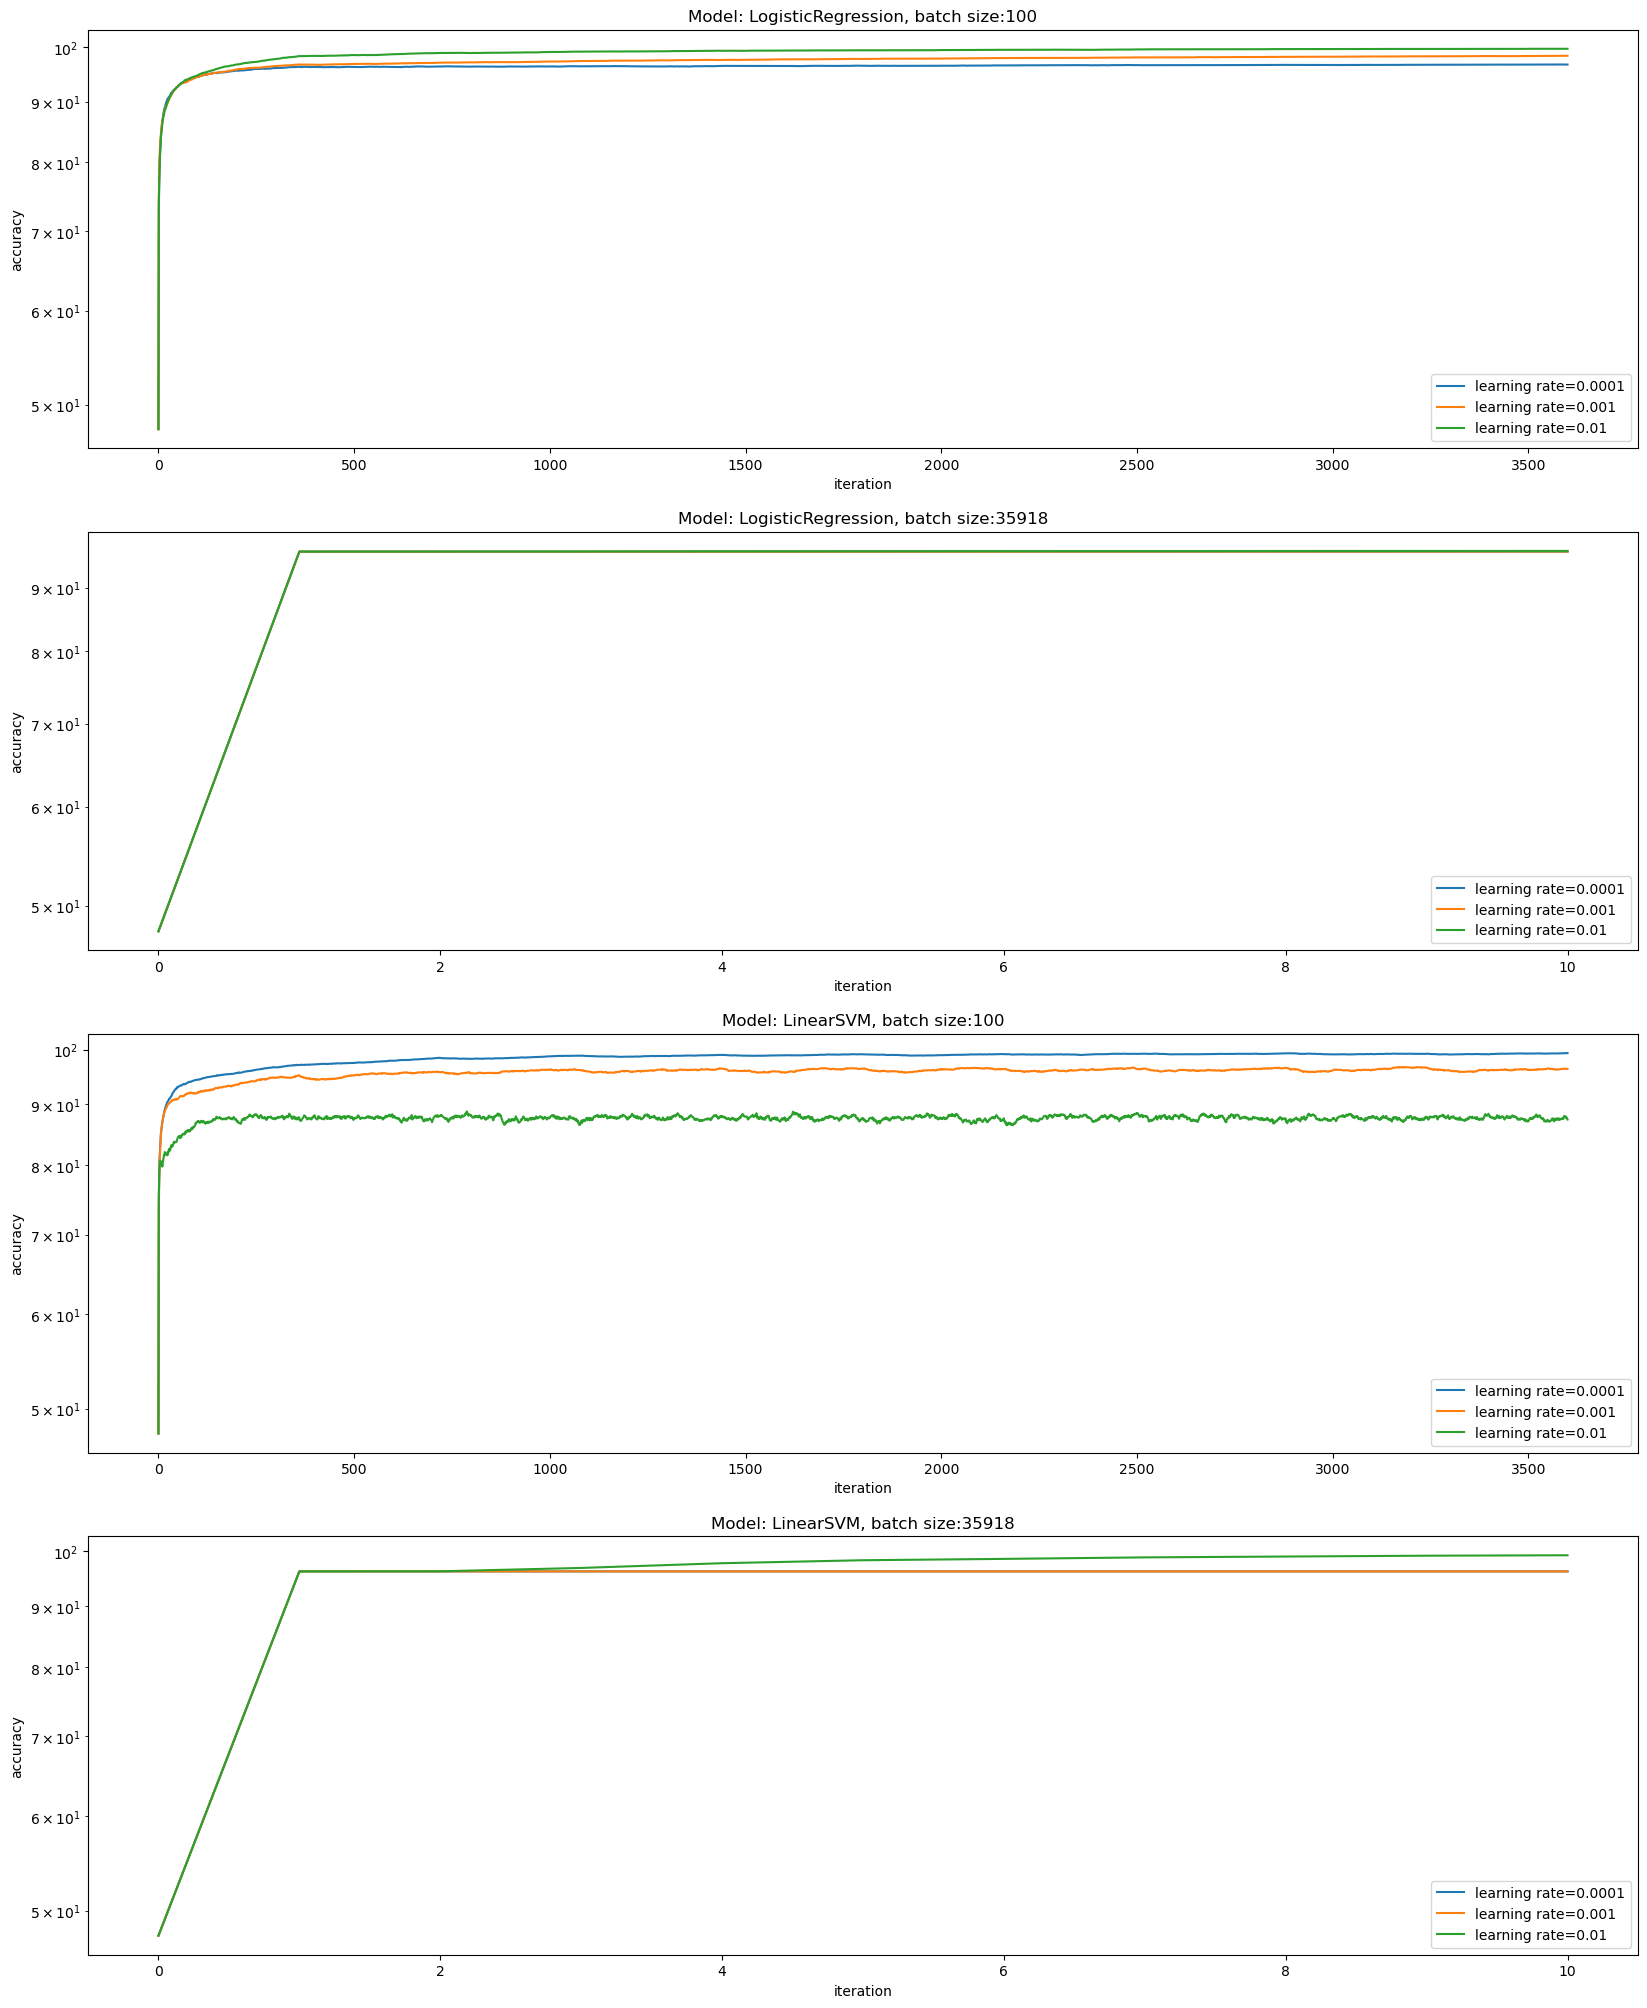

In [204]:
fig, ax=plt.subplots(int(len(result_df)/3), figsize=(20,25))
for lr in lrs:
    histories_lr=[(r,h) for (r,h) in histories if r['learning rate']==lr]
    for i,(r,h) in enumerate(histories_lr):
        ax[i].set_title(f"Model: {r['model']}, batch size:{r['batch size']}")
        ax[i].plot(range(len(h['accuracy'])), h['accuracy'],label= f"learning rate={lr}")
        ax[i].set_ylabel('accuracy')
        ax[i].set_xlabel('iteration')
        ax[i].set_yscale('log')
        ax[i].legend()

In [206]:
tokenizers={'None': None}
columns_list=[['title']]
models=['LogisticRegression']

lrs=[1e-6,1e-5,0.0001, 0.001, 0.01] # learining rates
max_features_list=[None] # list maximal features to consider
C_list=[10] #C values for SVM
hidden_layer_widths_list=[[10], [100]]  # list widths of hidden layers (everything except input and output layer)
vectorizations=['tf-idf']
stop_words_options=[None]
ngram_ranges=[(1,1)]
epochs_list=[100] #  number of epochs
bss=[100]# full batch
z_score_options=[True] #whether to apply z-score normalization after vectorization
sparse_options=[True]
activations=['ReLU']

result_df, histories=run_experiments(z_score_options,sparse_options, columns_list, models, C_list, hidden_layer_widths_list, vectorizations, tokenizers, stop_words_options, ngram_ranges,
                     max_features_list, activations, lrs, bss, epochs_list, compute_metrics=True, metrics_dict={'accuracy':None}, filename='Comparison_models.csv')

sparse,z-score,columns,model,# epochs,learning rate,batch size,C,widths,activation,vectorization,tokenizer,stop_words,ngram range,# features,train accuracy [%],test accuracy [%],vectorization time [s],training time [s]
True,True,['title'],LogisticRegression,100,0.000001,100,None,None,None,tf-idf,None,None,"(1, 1)",19616,96.302700,94.521200,0.620000,87.730000
True,True,['title'],LogisticRegression,100,0.000010,100,None,None,None,tf-idf,None,None,"(1, 1)",19616,96.692500,94.710500,0.620000,87.970000
True,True,['title'],LogisticRegression,100,0.000100,100,None,None,None,tf-idf,None,None,"(1, 1)",19616,98.351800,95.924300,0.620000,90.670000
True,True,['title'],LogisticRegression,100,0.001000,100,None,None,None,tf-idf,None,None,"(1, 1)",19616,99.693700,96.202700,0.620000,91.090000
True,True,['title'],LogisticRegression,100,0.010000,100,None,None,None,tf-idf,None,None,"(1, 1)",19616,100.000000,95.601300,0.620000,84.060000


TypeError: 'Axes' object is not subscriptable

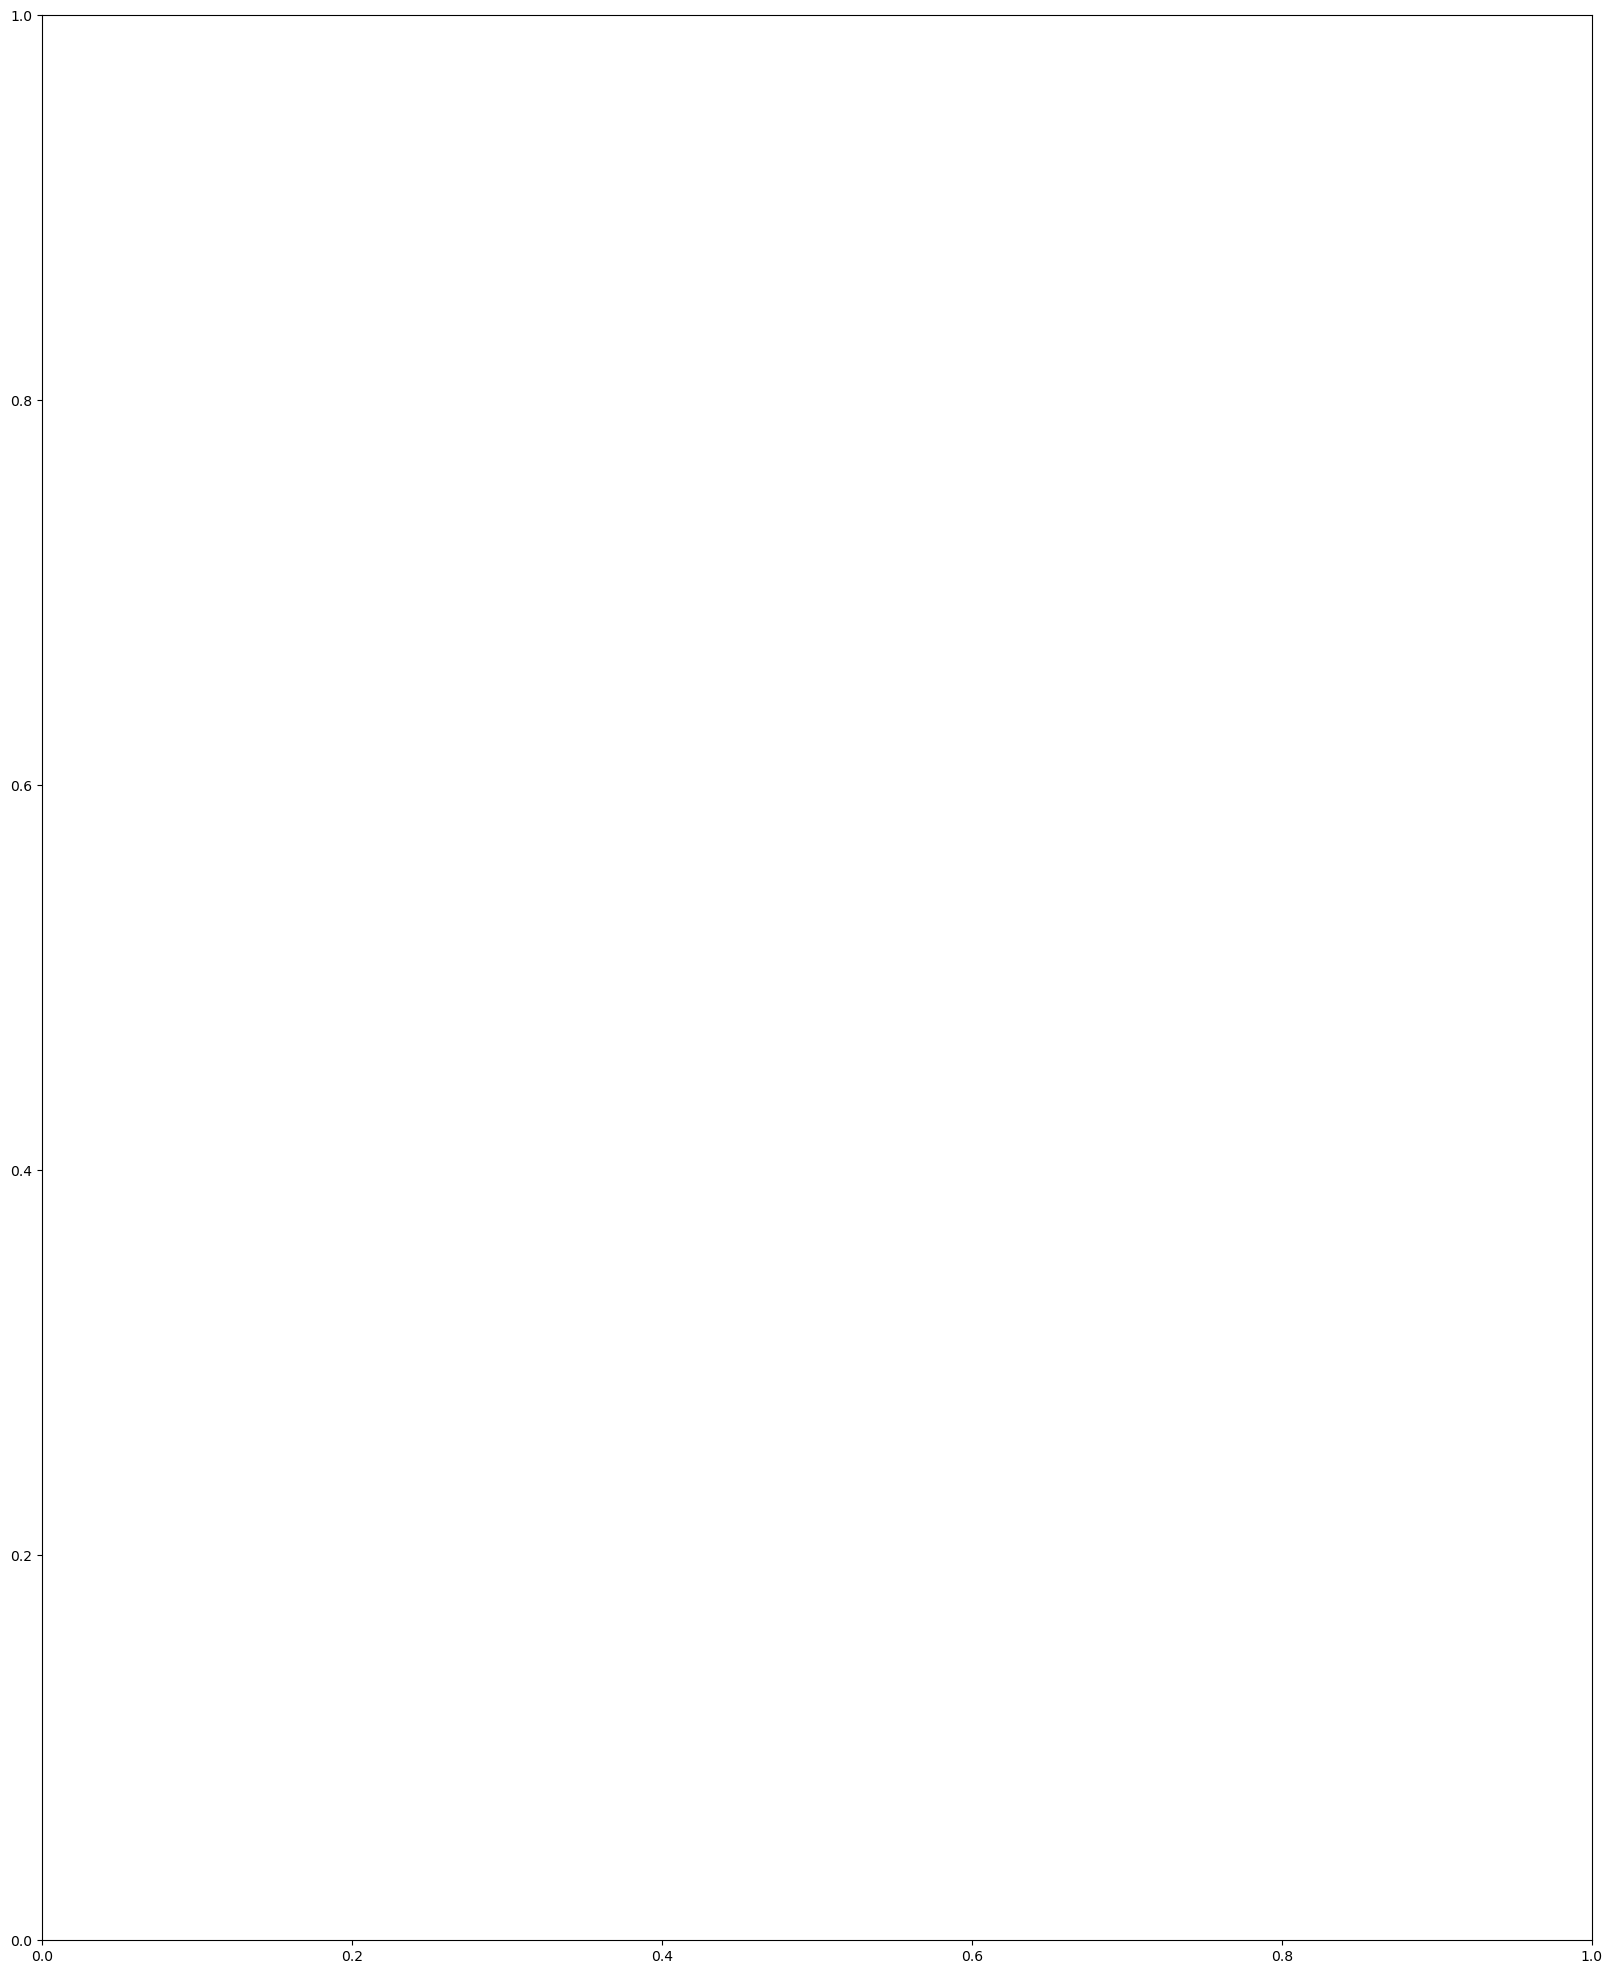

In [208]:
fig, ax=plt.subplots(int(len(result_df)/len(lrs)), figsize=(20,25))
for lr in lrs:
    histories_lr=[(r,h) for (r,h) in histories if r['learning rate']==lr]
    for i,(r,h) in enumerate(histories_lr):
        ax[i].set_title(f"Model: {r['model']}, batch size:{r['batch size']}")
        ax[i].plot(range(len(h['accuracy'])), h['accuracy'],label= f"learning rate={lr}")
        ax[i].set_ylabel('accuracy')
        ax[i].set_xlabel('iteration')
        ax[i].set_yscale('log')
        ax[i].legend()

In [226]:
tokenizers={'None': None}
columns_list=[['title']]
models=['LinearSVM']

lrs=[0.01,0.1,1, 10] # learining rates
max_features_list=[None] # list maximal features to consider
C_list=[10] #C values for SVM
hidden_layer_widths_list=[[10], [100]]  # list widths of hidden layers (everything except input and output layer)
vectorizations=['tf-idf']
stop_words_options=[None]
ngram_ranges=[(1,1)]
epochs_list=[1000] #  number of epochs
bss=[len(train_df)]# full batch
z_score_options=[True] #whether to apply z-score normalization after vectorization
sparse_options=[True]
activations=['ReLU']

result_df, histories=run_experiments(z_score_options,sparse_options, columns_list, models, C_list, hidden_layer_widths_list, vectorizations, tokenizers, stop_words_options, ngram_ranges,
                     max_features_list, activations, lrs, bss, epochs_list, compute_metrics=True, metrics_dict={'accuracy':None}, filename='Comparison_models.csv')

TypeError: 'int' object is not callable

In [ ]:
fig, ax=plt.subplots(int(len(result_df)/len(lrs)), figsize=(20,25))
for lr in lrs:
    histories_lr=[(r,h) for (r,h) in histories if r['learning rate']==lr]
    for i,(r,h) in enumerate(histories_lr):
        ax[i].set_title(f"Model: {r['model']}, batch size:{r['batch size']}")
        ax[i].plot(range(len(h['accuracy'])), h['accuracy'],label= f"learning rate={lr}")
        ax[i].set_ylabel('accuracy')
        ax[i].set_xlabel('iteration')
        ax[i].set_yscale('log')
        ax[i].legend()

In [211]:
vectorizer=multi_column_vectorizer(col_names=['title'])
X_train=vectorizer.fit_transform(train_df)
X_test=vectorizer.transform(test_df)

len=X_train.shape[0] #length of X_train

X=sp.vstack([X_train, X_test])
X, offset=standardize_sparse_matrix(X)
# X_train, X_test=X[:len], X[len:]
np.max(offset),np.min(offset), np.mean(offset)

(np.float64(0.6619805366004562),
 np.float64(0.0047194494498128845),
 np.float64(0.014952571395168477))

In [216]:
# Convert to COO for easy filtering
X_coo = X.tocoo()

# Test condition: X_ij < offset_j
condition = X_coo.data < offset[X_coo.col]

# Filtered results
rows = X_coo.row[condition]
cols = X_coo.col[condition]
vals = X_coo.data[condition]

# Optional: Combine as list of (i, j, value)
entries = list(zip(rows, cols, vals))

print("Entries where X_ij < offset_j:")
for i, j, v in entries:
    print(f"X[{i}, {j}] = {v}  (offset[{j}] = {offset[j]})")






Entries where X_ij < offset_j:


In [224]:
# Convert to COO for easy filtering
X_coo = X.tocoo()

# Test condition: X_ij < offset_j
condition = X_coo.data <= offset[X_coo.col]

# Filtered results
rows = X_coo.row[condition]
cols = X_coo.col[condition]
vals = X_coo.data[condition]

# Optional: Combine as list of (i, j, value)
entries = list(zip(rows, cols, vals))

print("Entries where X_ij < offset_j:")
for i, j, v in entries:
    print(f"X[{i}, {j}] = {v}  (offset[{j}] = {offset[j]})")

Entries where X_ij < offset_j:


In [ ]:
#Initialize model
model=LogisticRegression_S(w=np.zeros(len(train_df)), b=0, optimizer=GDOptimizer(0.01), offset=offset)

#Train model
train_start=time.time()
metrics_dict_=metrics_dict
if 'accuracy' in metrics_dict:
    metrics_dict_['accuracy']=ACCURACIES[modelname]
metrics_history=model.fit(X_train, y=y_train, num_epochs=mcf['# epochs'], batch_size=mcf['batch size'],
                        compute_metrics=compute_metrics, metrics_dict=metrics_dict_)
train_end=time.time()